# **PREPROCESSING DATA FOR BERT REGRESSION**

INSTALLS

In [2]:
!pip install ijson
!pip install shap
!pip install pdpbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


In [ ]:
shap.__version__

NameError: name 'shap' is not defined

IMPORTS

In [3]:
import re
import pandas as pd
import os
from tqdm import tqdm
import ijson
from sklearn.feature_extraction.text import TfidfVectorizer
import shap
from pdpbox import pdp
import joblib
import json
import gzip
import pdpbox
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import ndcg_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from google.colab import drive
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import PowerTransformer
import nltk
import ast
from nltk.corpus import stopwords
drive.mount('/content/drive')


ads_dataset_path = '/content/drive/MyDrive/CS491MLMODEL/us/us/ads.json'
ads_downsized_path = '/content/drive/MyDrive/CS491MLMODEL/us/us/ads_downsized.json'
ads_non_duplicate_path = '/content/drive/MyDrive/CS491MLMODEL/us/us/ads_non_duplicate.json'
ads_dataframe = '/content/drive/MyDrive/CS491MLMODEL/us/us/ads_dataframe.csv'
ads_non_duplicate_path = '/content/drive/MyDrive/CS491MLMODEL/us/us/ads_non_duplicate.json'
ads_dataframe_age_filtered = '/content/drive/MyDrive/CS491MLMODEL/us/us/ads_dataframe_age_filtered.csv'

Mounted at /content/drive


*DATA* DOWNSIZING

In [ ]:
json_item_heuristic = 3000000

def downsize_data(num_of_items, input_dataset_path, output_dataset_path):
    counter = 0
    with open(input_dataset_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item')

        with open(output_dataset_path, 'a') as outfile:  # Open output file once
            outfile.write('[\n')
            # Use tqdm to create a progress bar
            for item in tqdm(parser, total=int(num_of_items), unit=" items"):
                if counter > num_of_items:
                    break
                counter += 1
                json.dump(item, outfile)
                if counter > num_of_items:
                  outfile.write('\n')  # Add a newline between items
                else:
                  outfile.write(',\n')  # Add a newline between items

            outfile.write(']\n')
            outfile.close()

downsize_data(json_item_heuristic, ads_dataset_path, ads_downsized_path)

  0%|          | 1/3000000 [00:00<321:41:20,  2.59 items/s]

DATA DUPLICATE REMOVAL

In [ ]:
# @title
def remove_duplicates(filename, column, output_filename):
    json_item_heuristic = 3000
    first_item = True
    removed_content = 0
    unique_values = set()

    with open(filename, 'rb') as file:
        items = ijson.items(file, 'item')

        with open(output_filename, 'w') as outfile:
            outfile.write('[\n')
            for item in tqdm(items, total=int(json_item_heuristic), unit=" items"):
                if 'ad_creative_bodies' in item:
                    column_value = tuple(item['ad_creative_bodies'])

                    if (column_value not in unique_values) and (len(column_value) == 1):
                        unique_values.add(column_value)
                        if first_item:
                            json.dump(item, outfile)
                            first_item = False
                        else:
                            outfile.write(',\n')
                            json.dump(item, outfile)
                    else:
                        removed_content += 1
                else:
                    removed_content += 1
                    pass
            outfile.write(']\n')
    print(f"Amount of ads that have been filtered: {removed_content}")


remove_duplicates(ads_downsized_path, 'a', ads_non_duplicate_path)

3000001 items [06:16, 7961.98 items/s]


Amount of ads that have been filtered: 2800448


JSON TO CSV CONVERSION

In [ ]:
with open(ads_non_duplicate_path, 'r') as file:
    data = json.load(file)

processed_data = []
for item in data:
    selected_attributes = {'ad_creation_time': item['ad_creation_time'],
                           'ad_creative_bodies': item['ad_creative_bodies'],
                           'currency': item['currency'],
                           'impressions': item['impressions'],
                           'spend': item['spend']}
    processed_data.append(selected_attributes)

df = pd.DataFrame(processed_data)

df.to_csv(ads_dataframe, index=False)


LOAD DATAFRAME & GET INFORMATION

In [8]:
df = pd.read_csv(ads_dataframe)
print(df.dtypes)
df.head()

ad_creation_time      object
ad_creative_bodies    object
currency              object
impressions           object
spend                 object
dtype: object


,ad_creation_time,ad_creative_bodies,currency,impressions,spend
0,2021-12-07,['As the quotation on the wall of the Holocaus...,USD,"{'lower_bound': '10000', 'upper_bound': '14999'}","{'lower_bound': '300', 'upper_bound': '399'}"
1,2021-12-07,['We need to call out all discrimination – whe...,USD,"{'lower_bound': '4000', 'upper_bound': '4999'}","{'lower_bound': '100', 'upper_bound': '199'}"
2,2021-12-07,['Too many on the right seem only concerned ab...,USD,"{'lower_bound': '2000', 'upper_bound': '2999'}","{'lower_bound': '100', 'upper_bound': '199'}"
3,2021-12-07,['As the quotation on the wall of the Holocaus...,USD,"{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100', 'upper_bound': '199'}"
4,2021-12-07,"[""Too many on the right seem only concerned ab...",USD,"{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100', 'upper_bound': '199'}"


FEATURE EXTRACTION FROM DATAFRAME

In [9]:
new_df = pd.DataFrame()

new_df['ad_creation_time'] = pd.to_datetime(df['ad_creation_time'])
new_df['ad_creative_bodies'] = df['ad_creative_bodies'].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else x).astype(str)


# Extract 'lower_bound' and 'upper_bound' values if they exist, otherwise use NaN
new_df['impressions_lower'] = df['impressions'].apply(lambda x: ast.literal_eval(x).get('lower_bound', None)).astype("float")
new_df['impressions_upper'] = df['impressions'].apply(lambda x: ast.literal_eval(x).get('upper_bound', None)).astype("float")

new_df['spend_lower'] = df['spend'].apply(lambda x: ast.literal_eval(x).get('lower_bound', None)).astype("float")
new_df['spend_upper'] = df['spend'].apply(lambda x: ast.literal_eval(x).get('upper_bound', None)).astype("float")

print(new_df.dtypes)

new_df.head()

ad_creation_time      datetime64[ns]
ad_creative_bodies            object
impressions_lower            float64
impressions_upper            float64
spend_lower                  float64
spend_upper                  float64
dtype: object


,ad_creation_time,ad_creative_bodies,impressions_lower,impressions_upper,spend_lower,spend_upper
0,2021-12-07,As the quotation on the wall of the Holocaust ...,10000.0,14999.0,300.0,399.0
1,2021-12-07,We need to call out all discrimination – where...,4000.0,4999.0,100.0,199.0
2,2021-12-07,Too many on the right seem only concerned abou...,2000.0,2999.0,100.0,199.0
3,2021-12-07,As the quotation on the wall of the Holocaust ...,15000.0,19999.0,100.0,199.0
4,2021-12-07,Too many on the right seem only concerned abou...,15000.0,19999.0,100.0,199.0


CHECK FOR DUPLICATES

In [10]:
#Should print 0
new_df.duplicated(keep = False).sum()

0

DROP DUPLICATES FOR AD CREATIVE BODIES AND REMOVE NAN VALUES FOR

In [11]:
new_df.drop_duplicates(subset = "ad_creative_bodies", keep=False, inplace=True)
columns_to_check = ['impressions_lower', 'impressions_upper', 'spend_lower', 'spend_upper']
new_df = new_df.dropna(subset=columns_to_check)

CHECK MISSING VALUE RATES IN FEATURES

In [12]:
new_df.isna().sum()/len(df)

ad_creation_time      0.0
ad_creative_bodies    0.0
impressions_lower     0.0
impressions_upper     0.0
spend_lower           0.0
spend_upper           0.0
dtype: float64

MERGE COLUMNS AND SORT ACCORDING TO DATE

In [13]:
ads_dataframe = pd.DataFrame()
ads_dataframe['ad_creation_time'] = new_df['ad_creation_time']
ads_dataframe['ad_creative_bodies'] = new_df['ad_creative_bodies']
ads_dataframe['spend'] = (new_df['spend_lower'].fillna(new_df['spend_upper']) / 2 +
     new_df['spend_upper'].fillna(new_df['spend_lower']) / 2)
ads_dataframe['impressions'] = (new_df['impressions_lower'].fillna(new_df['impressions_upper']) / 2 +
     new_df['impressions_upper'].fillna(new_df['impressions_lower']) / 2)

ads_dataframe = ads_dataframe.sort_values(by='ad_creation_time')
ads_dataframe

,ad_creation_time,ad_creative_bodies,spend,impressions
5910,2014-06-12,ActiveGuard® is the first mattress liner to ac...,4749.5,112499.5
14593,2014-07-17,"Mark Segal, PGN publisher, is the nation’s mos...",449.5,64999.5
18282,2015-02-20,"Architecture, Engineering, Construction. \nInt...",649.5,9499.5
24367,2015-04-16,Conservative Political Commentary & Humor!,249.5,47499.5
25900,2015-06-15,First step in finding the right Dentist? Resea...,249.5,22499.5
...,...,...,...,...
106361,2021-12-28,DEADLINE EXTENSION: The time to act for the Ar...,49.5,499.5
106362,2021-12-28,Our natural world is facing an unprecedented c...,49.5,499.5
106363,2021-12-28,The time is NOW >>> Your donation will go 10X ...,49.5,499.5
144518,2021-12-28,"If you were molested as a child by a priest, t...",49.5,1499.5


SEPERATE TRAIN AND TEST

In [14]:
# Determine the split index
split_value = 0.1
split_index = int(split_value * len(ads_dataframe))

train_data = ads_dataframe.iloc[:split_index]
test_data = ads_dataframe.iloc[split_index:]

CHECK FOR OUTLIERS

In [18]:
continuous_numerical = [
    'spend',
    'impressions'
    ]

train_data[continuous_numerical].describe([0.1, 0.25, 0.5, 0.75, 0.9,
                                 0.99])

,spend,impressions
count,19406.000000,19406.000000
mean,4.988692,8.851748
std,1.322566,1.990313
min,3.901973,6.213608
10%,3.901973,6.213608
25%,3.901973,7.312887
50%,3.901973,8.922592
75%,5.856504,10.388980
90%,7.130499,11.461627
99%,8.465795,12.959843


REMOVE OUTLIERS (SINCE THE MAX IS MUCH HIGHER THAN THE 99TH PERCENTILE, AND VICE VERSA)

In [16]:
def remove_outliers(df, lower_outliers, q_bottom, upper_outliers,
                    q_top):
    lower_quantiles = df[lower_outliers].quantile(q_bottom)
    for col in lower_outliers:
        df = df[df[col] >= lower_quantiles[col]]
    upper_quantiles = df[upper_outliers].quantile(q_top)
    for col in upper_outliers:
        df = df[df[col] <= upper_quantiles[col]]
    return df

upper_outliers = ['spend', 'impressions']
lower_outliers = ['spend', 'impressions']
train_data = remove_outliers(train_data, lower_outliers, 0.01, upper_outliers, 0.99)

SKEWNESS ANALYSIS

In [ ]:
#train_data.drop(columns=['ad_creation_time', 'ad_creative_bodies']).skew().sort_values(ascending=False)

spend_lower          20.078676
spend_upper          18.743810
impressions_lower     4.738904
impressions_upper     4.605087
dtype: float64

LOG TRANSFORMATION FOR SKEWED DATA

In [17]:
# Apply log transformation only to specific columns
train_data['spend'] = np.log(train_data['spend'])
train_data['impressions'] = np.log(train_data['impressions'])

# **PREDICTION WITH SUPERVISED LEARNING**

VECTORIZE TEXTUAL CONTENT

In [ ]:
def tokenize_and_remove_stopwords(text):
  # Remove URLs from the text
    text = re.sub(r'http\S+', '', text)

    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

def generate_doc_vectors(docs, model, num_features):
    doc_vectors = [average_word_vectors(doc, model, model.wv.index_to_key, num_features) for doc in docs]
    return np.array(doc_vectors)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

X_train = train_data['ad_creative_bodies'].astype(str)
y_train = train_data['cpi']

X_test = test_data['ad_creative_bodies'].astype(str)
y_test = test_data['cpi']

# Tokenization and stopword removal
tokenized_text_train = X_train.apply(tokenize_and_remove_stopwords)
tokenized_text_test = X_test.apply(tokenize_and_remove_stopwords)

# Word2Vec model training
word2vec_model = Word2Vec(sentences=tokenized_text_train, vector_size=100, window=5, min_count=1, workers=4)

# Generate document vectors
X_train_word2vec = generate_doc_vectors(tokenized_text_train, word2vec_model, 100)
X_test_word2vec = generate_doc_vectors(tokenized_text_test, word2vec_model, 100)

word2vec_model.save("word2vec_model.model")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SAVE WORD2VEC MODEL

In [ ]:
word2vec_model.save('/content/drive/MyDrive/CS491MLMODEL/us/us/word2vec_model.model')

TRAIN ML MODEL

In [ ]:
# Model training and evaluation
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_regressor.fit(X_train_word2vec, y_train)

GradientBoostingRegressor(random_state=42)

SAVE MODEL

In [ ]:
joblib.dump(gb_regressor, '/content/drive/MyDrive/CS491MLMODEL/us/us/gradient_boosting_model.pkl')
#loaded_model = joblib.load('/content/drive/MyDrive/CS491MLMODEL/us/us/gradient_boosting_model.pkl')

['/content/drive/MyDrive/CS491MLMODEL/us/us/gradient_boosting_model.pkl']

LOAD MODEL (RUN IF YOU DO NOT WANT TO TRAIN)

In [ ]:
gb_regressor = joblib.load('/content/drive/MyDrive/CS491MLMODEL/us/us/gradient_boosting_model.pkl')


TEST WITH NDCG

In [ ]:
# Function to create subsets of data
def create_data_subsets(data, group_size):
    grouped_data = [data.iloc[i : i + group_size] for i in range(0 , data.shape[0], group_size)]
    return grouped_data

def calculate_ndcg_for_groups(groups, model):
    ndcg_scores = []
    for group in tqdm(groups, total=len(groups), unit=" items"):
        tokenized_X_train_group = group['ad_creative_bodies'].apply(tokenize_and_remove_stopwords)
        X_train_word2vec_group = generate_doc_vectors(tokenized_X_train_group, word2vec_model, 100)

        y_group_pred = model.predict(X_train_word2vec_group)

        # Assuming lower CPI values are more relevant
        relevance_scores = 1 / y_group_pred

        # Normalize relevance scores (optional)
        #relevance_scores = (relevance_scores - np.min(relevance_scores)) / (np.max(relevance_scores) - np.min(relevance_scores))

        y_group_true = 1 / group['cpi'].values

        try:
            ndcg = ndcg_score([y_group_true], [relevance_scores])
            ndcg_scores.append(ndcg)
        except Exception as e:
            print(y_group_true)
            print(relevance_scores)

    return ndcg_scores

group_size = 4
test_data_subsets = create_data_subsets(test_data, group_size)

ndcg_scores = calculate_ndcg_for_groups(test_data_subsets, gb_regressor)

NameError: name 'test_data' is not defined

PRINT NDCG SCORES

In [ ]:
# Combine NDCG scores across groups (simple average in this example)
average_ndcg_across_groups = sum(ndcg_scores) / len(ndcg_scores)

print(f"Average NDCG Across Groups: {round(average_ndcg_across_groups,2)}")

Average NDCG Across Groups: 0.87


# **RECOMMENDATION MODEL**

In [ ]:
# Determine the split index
split_index = int(0.8 * len(ads_dataframe))

train_data = ads_dataframe.iloc[:split_index]
test_data = ads_dataframe.iloc[split_index:]

# Function to remove URLs
def remove_urls(text):
    # Use regular expressions to remove URLs and keywords with case insensitivity
    text = re.sub(r'\bsmartnews\b', '', text, flags=re.IGNORECASE)  # Whole word match for 'smartnews'
    text = re.sub(r'\bnews\b', '', text, flags=re.IGNORECASE)       # Whole word match for 'news'
    return re.sub(r'http\S+', '', text)


# Vectorize the text data using TF-IDF
max_features = 2000  # Choose the top most important words
vectorizer = TfidfVectorizer(max_features = max_features, stop_words='english')
X_train_suggestion = vectorizer.fit_transform(train_data['ad_creative_bodies'].apply(remove_urls))
X_test_suggestion = vectorizer.transform(test_data['ad_creative_bodies'].apply(remove_urls))

# Train a regression model
gb_regressor_suggestion = GradientBoostingRegressor(n_estimators=200, learning_rate=0.001, random_state=42, loss="absolute_error")
gb_regressor_suggestion.fit(X_train_suggestion, train_data['cpi'])

GradientBoostingRegressor(learning_rate=0.001, loss='absolute_error',
                          n_estimators=200, random_state=42)

GRID SEARCH (RUN WHEN YOU WANT TO TEST POSSIBLE PARAMETERS)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Example feature and target arrays (X, y)
# X, y = your_data.features, your_data.target

# Setting up parameter grid
param_grid = {
    'loss': ['absolute_error'],
    'n_estimators': [200, 500],
    'learning_rate': [0.01, 0.001],
}

# Create a GradientBoostingRegressor object
gb_regressor = GradientBoostingRegressor(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit grid search
grid_search.fit(X_train_suggestion, train_data['cpi'])

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (MSE):", -grid_search.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'learning_rate': 0.001, 'loss': 'absolute_error', 'n_estimators': 200}
Best cross-validation score (MSE): 0.008877012857417802


PARTIAL DEPENDENCE PLOT

In [ ]:
# Choose a feature for the Partial Dependence Plot (e.g., the first feature)
feature_index = 1
feature_name = vectorizer.get_feature_names_out()[feature_index]

# Create the Partial Dependence Plot.
pdp_plotter = pdpbox.pdp.PDPIsolate(gb_regressor_suggestion, pd.DataFrame.sparse.from_spmatrix(X_test_suggestion, columns = vectorizer.get_feature_names_out()), vectorizer.get_feature_names_out(), feature_name, feature_name, n_classes=0)
pdp_plot = pdp_plotter.plot()
pdp_plot[0]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
pdp_plot[0]

SHAP VALUE

In [ ]:
import matplotlib.pyplot as plt
import shap

def shap_value_plot(feature_names, shap_values_instance):
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(feature_names, shap_values_instance[0], color='lightblue')
    plt.title('SHAP values for instance index {}'.format(instance_index))
    plt.xlabel('Feature')
    plt.ylabel('SHAP value')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
joblib.dump(gb_regressor_suggestion, '/content/drive/MyDrive/CS491MLMODEL/us/us/gb_regressor_suggestion.joblib')

['/content/drive/MyDrive/CS491MLMODEL/us/us/gb_regressor_suggestion.joblib']

[[0. 0. 0. ... 0. 0. 0.]]
Let's put Scranton values back in the White House.


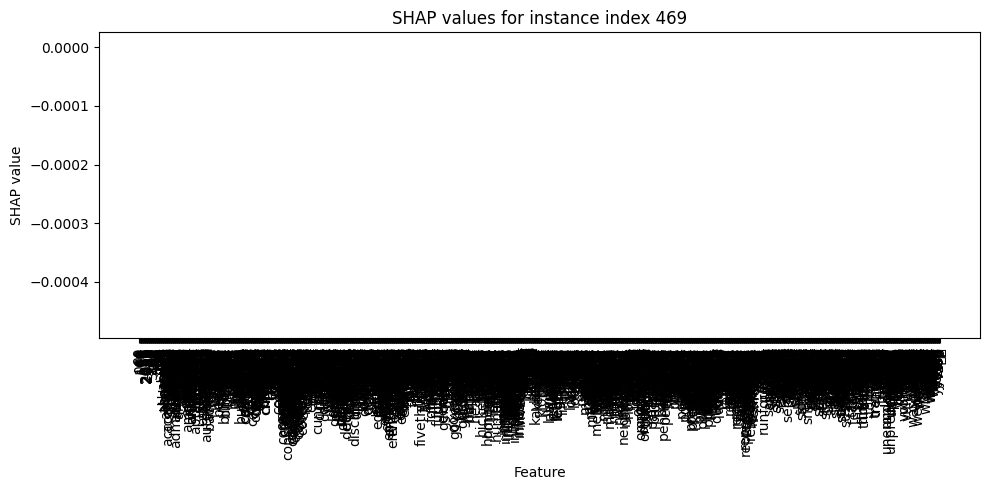

In [ ]:
feature_names = vectorizer.get_feature_names_out()

explainer = shap.TreeExplainer(gb_regressor_suggestion)

instance_index = 469  # Index of the instance in the test set

single_instance = X_test_suggestion[instance_index].toarray()

print(single_instance)
print(test_data['ad_creative_bodies'][instance_index])
# Calculate SHAP values for the single instance
shap_values_single = explainer.shap_values(single_instance)

# Extract the SHAP values for the instance
shap_values_instance = shap_values_single[0] if isinstance(shap_values_single, list) else shap_values_single

shap_value_plot(feature_names, shap_values_instance)

# **AGE-GENDER FILTERING**

JSON TO CSV CONVERSION (AGE-GENDER FILTERING)

In [ ]:
with open(ads_non_duplicate_path, 'r') as file:
    data = json.load(file)

processed_data = []

for item in data:

    selected_attributes = {
        'ad_creation_time': item.get('ad_creation_time'),
        'ad_creative_bodies': item.get('ad_creative_bodies'),
        'currency': item.get('currency'),
        'impressions': item.get('impressions'),
        'spend': item.get('spend'),
        'delivery_by_region': item.get('delivery_by_region', []),
        'demographic_distribution': item.get('demographic_distribution', [])
    }
    processed_data.append(selected_attributes)

df_age_filtered = pd.DataFrame(processed_data)

df_age_filtered.to_csv(ads_dataframe_age_filtered, index=False)

LOAD DATAFRAME (AGE-GENDER FILTERING) & GET INFORMATION

In [ ]:
df_age_filtered = pd.read_csv(ads_dataframe_age_filtered)
print(df_age_filtered.dtypes)
df_age_filtered.head()

ad_creation_time            object
ad_creative_bodies          object
currency                    object
impressions                 object
spend                       object
delivery_by_region          object
demographic_distribution    object
dtype: object


,ad_creation_time,ad_creative_bodies,currency,impressions,spend,delivery_by_region,demographic_distribution
0,2021-12-07,['As the quotation on the wall of the Holocaus...,USD,"{'lower_bound': '10000', 'upper_bound': '14999'}","{'lower_bound': '300', 'upper_bound': '399'}","[{'percentage': '0.002039', 'region': 'Hawaii'...","[{'percentage': '0.000213', 'age': '18-24', 'g..."
1,2021-12-07,['We need to call out all discrimination – whe...,USD,"{'lower_bound': '4000', 'upper_bound': '4999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.0003', 'region': 'Wyoming'}...","[{'percentage': '0.001782', 'age': '45-54', 'g..."
2,2021-12-07,['Too many on the right seem only concerned ab...,USD,"{'lower_bound': '2000', 'upper_bound': '2999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.002145', 'region': 'Alaska'...","[{'percentage': '0.000423', 'age': '45-54', 'g..."
3,2021-12-07,['As the quotation on the wall of the Holocaus...,USD,"{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.002674', 'region': 'Delawar...","[{'percentage': '0.016002', 'age': '25-34', 'g..."
4,2021-12-07,"[""Too many on the right seem only concerned ab...",USD,"{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.009534', 'region': 'Alabama...","[{'percentage': '0.000757', 'age': '35-44', 'g..."


CONVERT INTO DATAFRAME (AGE-GENDER FILTERING)


In [ ]:
new_df_age_filtered = pd.DataFrame()

# Convert 'ad_creation_time' to datetime
new_df_age_filtered['ad_creation_time'] = pd.to_datetime(df_age_filtered['ad_creation_time'])

# Extract 'ad_creative_bodies'
new_df_age_filtered['ad_creative_bodies'] = df_age_filtered['ad_creative_bodies'].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else x).astype(str)

# Extract 'lower_bound' and 'upper_bound' values for impressions and spend
new_df_age_filtered['impressions_lower'] = df_age_filtered['impressions'].apply(lambda x: ast.literal_eval(x).get('lower_bound', None)).astype("float")
new_df_age_filtered['impressions_upper'] = df_age_filtered['impressions'].apply(lambda x: ast.literal_eval(x).get('upper_bound', None)).astype("float")
new_df_age_filtered['spend_lower'] = df_age_filtered['spend'].apply(lambda x: ast.literal_eval(x).get('lower_bound', None)).astype("float")
new_df_age_filtered['spend_upper'] = df_age_filtered['spend'].apply(lambda x: ast.literal_eval(x).get('upper_bound', None)).astype("float")

# Create columns for unique region names
'''
unique_regions = set()
for item in df['delivery_by_region']:
    try:
        regions = ast.literal_eval(item)
        for region in regions:
            if 'region' in region:
                unique_regions.add(region['region'])
    except (SyntaxError, ValueError):
        pass

for region in unique_regions:
    new_df_age_filtered[f'percentage_{region}'] = None
'''
# Create columns for age intervals
unique_age_intervals = set()
for item in df_age_filtered['demographic_distribution']:
    try:
        demographics = ast.literal_eval(item)
        for demographic in demographics:
            age = demographic.get('age', None)
            gender = demographic.get('gender', None)
            if age is not None and gender is not None:
                age_gender_key = f'{age}_{gender}'
                unique_age_intervals.add(age_gender_key)
    except (SyntaxError, ValueError):
        pass

for age_interval in unique_age_intervals:
    new_df_age_filtered[f'percentage_{age_interval}'] = None
'''
# Iterate through the data to fill in information or use percentages as empty
for i, item in enumerate(df['delivery_by_region']):
    try:
        regions = ast.literal_eval(item)
        for region in regions:
            if 'region' in region:
                new_df_age_filtered.at[i, f'percentage_{region["region"]}'] = region.get('percentage', None)
    except (SyntaxError, ValueError):
        pass
'''
for i, item in enumerate(df_age_filtered['demographic_distribution']):
    try:
        demographics = ast.literal_eval(item)
        for demographic in demographics:
            age = demographic.get('age', None)
            gender = demographic.get('gender', None)
            if age is not None and gender is not None:
                age_gender_key = f'{age}_{gender}'
                new_df_age_filtered.at[i, f'percentage_{age_gender_key}'] = demographic.get('percentage', None)
    except (SyntaxError, ValueError):
        pass

# Display data types and the head of the new DataFrame
print(new_df_age_filtered.dtypes)
new_df_age_filtered.head()

ad_creation_time              datetime64[ns]
ad_creative_bodies                    object
impressions_lower                    float64
impressions_upper                    float64
spend_lower                          float64
spend_upper                          float64
percentage_65+_female                 object
percentage_25-34_male                 object
percentage_65+_unknown                object
percentage_25-34_female               object
percentage_55-64_male                 object
percentage_35-44_unknown              object
percentage_Unknown_unknown            object
percentage_13-17_female               object
percentage_13-17_male                 object
percentage_35-44_female               object
percentage_55-64_female               object
percentage_18-24_female               object
percentage_45-54_unknown              object
percentage_25-34_unknown              object
percentage_65+_male                   object
percentage_35-44_male                 object
percentage

,ad_creation_time,ad_creative_bodies,impressions_lower,impressions_upper,spend_lower,spend_upper,percentage_65+_female,percentage_25-34_male,percentage_65+_unknown,percentage_25-34_female,...,percentage_45-54_unknown,percentage_25-34_unknown,percentage_65+_male,percentage_35-44_male,percentage_13-17_unknown,percentage_18-24_unknown,percentage_55-64_unknown,percentage_45-54_female,percentage_45-54_male,percentage_18-24_male
0,2021-12-07,As the quotation on the wall of the Holocaust ...,10000.0,14999.0,300.0,399.0,0.064646,0.173418,0.00202,0.029027,...,0.002764,0.001382,0.055821,0.188836,None,0.000213,0.001595,0.074854,0.142584,0.029452
1,2021-12-07,We need to call out all discrimination – where...,4000.0,4999.0,100.0,199.0,0.183546,0.041283,0.003861,0.019305,...,0.001782,0.001485,0.079002,0.06237,None,None,0.001188,0.144936,0.102762,0.012177
2,2021-12-07,Too many on the right seem only concerned abou...,2000.0,2999.0,100.0,199.0,0.109514,0.121353,0.002537,0.059197,...,0.000423,0.002537,0.050317,0.07907,None,None,0.001691,0.127273,0.07907,0.054123
3,2021-12-07,As the quotation on the wall of the Holocaust ...,15000.0,19999.0,100.0,199.0,0.15853,0.07757,0.003119,0.016002,...,0.001899,0.000678,0.12856,0.112558,None,None,0.002441,0.071196,0.125576,0.014375
4,2021-12-07,Too many on the right seem only concerned abou...,15000.0,19999.0,100.0,199.0,0.334306,0.032003,0.004757,0.013299,...,0.001297,0.000973,0.18229,0.04195,None,None,0.002162,0.06098,0.061953,0.007785


MERGE COLUMNS AND SORT ACCORDING TO DATE (AGE-GENDER FILTERING)

In [ ]:
ads_dataframe_age_filtered = new_df_age_filtered.copy(deep=True)
ads_dataframe_age_filtered['cpi'] = (
    (new_df_age_filtered['spend_lower'].fillna(new_df_age_filtered['spend_upper']) / 2 +
     new_df_age_filtered['spend_upper'].fillna(new_df_age_filtered['spend_lower']) / 2) /
    (new_df_age_filtered['impressions_lower'].fillna(new_df_age_filtered['impressions_upper']) / 2 +
     new_df_age_filtered['impressions_upper'].fillna(new_df_age_filtered['impressions_lower']) / 2)
)
print(type(ads_dataframe_age_filtered))
ads_dataframe_age_filtered = ads_dataframe_age_filtered.drop(columns=['impressions_lower', 'impressions_upper', 'spend_lower', 'spend_upper'])
ads_dataframe_age_filtered = ads_dataframe_age_filtered.sort_values(by='ad_creation_time')

ads_dataframe_age_filtered

<class 'pandas.core.frame.DataFrame'>


,ad_creation_time,ad_creative_bodies,percentage_65+_female,percentage_25-34_male,percentage_65+_unknown,percentage_25-34_female,percentage_55-64_male,percentage_35-44_unknown,percentage_Unknown_unknown,percentage_13-17_female,...,percentage_25-34_unknown,percentage_65+_male,percentage_35-44_male,percentage_13-17_unknown,percentage_18-24_unknown,percentage_55-64_unknown,percentage_45-54_female,percentage_45-54_male,percentage_18-24_male,cpi
5910,2014-06-12,ActiveGuard® is the first mattress liner to ac...,0.101909,0.061994,0.000176,0.104819,0.04822,0.000778,None,None,...,0.000502,0.029554,0.079054,None,0.0001,0.000502,0.153441,0.064402,0.011164,0.042218
14593,2014-07-17,"Mark Segal, PGN publisher, is the nation’s mos...",0.144548,0.04014,0.001353,0.027512,0.087045,None,None,0.153118,...,0.001579,0.092006,0.025031,0.003157,0.00203,0.000677,0.018942,0.047807,0.073514,0.006915
18282,2015-02-20,"Architecture, Engineering, Construction. \nInt...",0.181985,0.102223,0.001834,0.03438,0.117121,0.001834,None,None,...,0.001146,0.13477,0.079762,None,0.000344,0.001834,0.060738,0.109787,0.0314,0.068372
24367,2015-04-16,Conservative Political Commentary & Humor!,0.015606,0.121729,0.00048,0.014406,0.169028,0.002401,None,0.00024,...,0.00072,0.085954,0.212005,None,None,0.001441,0.029532,0.254022,0.026891,0.005253
25900,2015-06-15,First step in finding the right Dentist? Resea...,0.333453,None,None,None,None,None,None,None,...,None,None,None,None,None,None,0.286791,None,None,0.011089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93977,2021-12-28,It was one of the best nights of my career. No...,0.509202,None,0.006135,0.018405,0.055215,None,None,None,...,None,0.276074,0.006135,None,None,0.006135,0.01227,0.018405,None,0.099099
106359,2021-12-28,Follow four young people in Tucson as they lea...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0.099099
66492,2021-12-28,DEVELOPING... the most significant environment...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0.099099
68581,2021-12-28,The right education can make all the differenc...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0.099099


SAMPLE AGE-GENDER FILTERING DATASET SEPERATION

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

# Determine the split index
split_index = int(0.8 * ads_dataframe_age_filtered.shape[0])

train_data = ads_dataframe_age_filtered.iloc[:split_index]
test_data = ads_dataframe_age_filtered.iloc[split_index:]

gender_data_train = pd.DataFrame({
    'ad_creative_bodies': train_data['ad_creative_bodies'].astype(str),
    'percentage_25-34_male': train_data['percentage_25-34_male'].astype(str),
    'percentage_25-34_female': train_data['percentage_25-34_female'].astype(str),
    'percentage_35-44_male': train_data['percentage_35-44_male'].astype(str),
    'percentage_13-17_male': train_data['percentage_13-17_male'].astype(str),
    'percentage_55-64_male': train_data['percentage_55-64_male'].astype(str),
    'percentage_18-24_male': train_data['percentage_18-24_male'].astype(str),
    'percentage_65+_male': train_data['percentage_65+_male'].astype(str),
    'percentage_35-44_female': train_data['percentage_35-44_female'].astype(str),
    'percentage_13-17_female': train_data['percentage_13-17_female'].astype(str),
    'percentage_55-64_female': train_data['percentage_55-64_female'].astype(str),
    'percentage_18-24_female': train_data['percentage_18-24_female'].astype(str),
    'percentage_65+_female': train_data['percentage_65+_female'].astype(str),
    'percentage_45-54_male': train_data['percentage_45-54_male'].astype(str),
    'percentage_45-54_female': train_data['percentage_45-54_female'].astype(str),
    'cpi': train_data['cpi']
})

# Remove rows with 'None' values in the first two columns
gender_data_train.replace('None', np.nan, inplace=True)  # Replace 'None' with NaN
gender_data_train.dropna(subset=['percentage_25-34_male',
    'percentage_25-34_female',
    'percentage_35-44_male',
    'percentage_13-17_male',
    'percentage_55-64_male',
    'percentage_18-24_male',
    'percentage_65+_male',
    'percentage_35-44_female',
    'percentage_13-17_female',
    'percentage_55-64_female',
    'percentage_18-24_female',
    'percentage_65+_female',
    'percentage_45-54_male',
    'percentage_45-54_female'], how='any', inplace=True)

y_train_gendered = gender_data_train['cpi']
X_train_2 = gender_data_train['ad_creative_bodies']
gender_data_train.drop(columns=['cpi', 'ad_creative_bodies'], axis=1, inplace=True)

gender_data_test = pd.DataFrame({
    'ad_creative_bodies': test_data['ad_creative_bodies'].astype(str),
    'percentage_25-34_male': test_data['percentage_25-34_male'].astype(str),
    'percentage_25-34_female': test_data['percentage_25-34_female'].astype(str),
    'percentage_35-44_male': test_data['percentage_35-44_male'].astype(str),
    'percentage_13-17_male': test_data['percentage_13-17_male'].astype(str),
    'percentage_55-64_male': test_data['percentage_55-64_male'].astype(str),
    'percentage_18-24_male': test_data['percentage_18-24_male'].astype(str),
    'percentage_65+_male': test_data['percentage_65+_male'].astype(str),
    'percentage_35-44_female': test_data['percentage_35-44_female'].astype(str),
    'percentage_13-17_female': test_data['percentage_13-17_female'].astype(str),
    'percentage_55-64_female': test_data['percentage_55-64_female'].astype(str),
    'percentage_18-24_female': test_data['percentage_18-24_female'].astype(str),
    'percentage_65+_female': test_data['percentage_65+_female'].astype(str),
    'percentage_45-54_male': test_data['percentage_45-54_male'].astype(str),
    'percentage_45-54_female': test_data['percentage_45-54_female'].astype(str),
    'cpi': test_data['cpi']
})

# Remove rows with 'None' values in the first two columns
gender_data_test.replace('None', np.nan, inplace=True)  # Replace 'None' with NaN
gender_data_test.dropna(subset=['percentage_25-34_male',
    'percentage_25-34_female',
    'percentage_35-44_male',
    'percentage_13-17_male',
    'percentage_55-64_male',
    'percentage_18-24_male',
    'percentage_65+_male',
    'percentage_35-44_female',
    'percentage_13-17_female',
    'percentage_55-64_female',
    'percentage_18-24_female',
    'percentage_65+_female',
    'percentage_45-54_male',
    'percentage_45-54_female'], how='any', inplace=True)

y_test_gendered = gender_data_test['cpi']
X_test_2 = gender_data_test['ad_creative_bodies']
gender_data_test.drop('cpi', axis=1, inplace=True)

In [ ]:
# Tokenization and stopword removal
tokenized_text_train_2 = X_train_2.apply(tokenize_and_remove_stopwords)
tokenized_text_test_2 = X_test_2.apply(tokenize_and_remove_stopwords)

# Word2Vec model training
word2vec_model = Word2Vec(sentences=tokenized_text_train_2, vector_size=100, window=5, min_count=1, workers=4)

# Generate document vectors
X_train_word2vec_2 = generate_doc_vectors(tokenized_text_train_2, word2vec_model, 100)
X_test_word2vec_2 = generate_doc_vectors(tokenized_text_test_2, word2vec_model, 100)

#word2vec_model.save("word2vec_model.model")

In [ ]:
gender_data_train.reset_index(drop=True, inplace=True)
gender_data_test.reset_index(drop=True, inplace=True)

combined_train_data = pd.concat([gender_data_train, pd.DataFrame(X_train_word2vec_2)], axis=1)
combined_test_data = pd.concat([gender_data_test, pd.DataFrame(X_test_word2vec_2)], axis=1)

combined_train_data.columns = combined_train_data.columns.astype(str)
combined_test_data.columns = combined_test_data.columns.astype(str)
combined_test_data.drop(columns=['ad_creative_bodies'], inplace=True)##Comment when not necessary

# Initialize the Gradient Boosting Regressor
gb_model_gender = GradientBoostingRegressor(n_estimators=200, learning_rate=0.001, random_state=42, loss="absolute_error")

# Fit the model
gb_model_gender.fit(combined_train_data, y_train_gendered)

GradientBoostingRegressor(learning_rate=0.001, loss='absolute_error',
                          n_estimators=200, random_state=42)

SAVE GENDERED MODEL

In [ ]:
joblib.dump(gb_model_gender, '/content/drive/MyDrive/CS491MLMODEL/us/us/gb_model_gender.joblib')

['/content/drive/MyDrive/CS491MLMODEL/us/us/gb_model_gender.joblib']

SHAP VALUE FOR GENDER COLUMNS

In [ ]:
print(feature_names)

['percentage_25-34_male', 'percentage_25-34_female', 'percentage_35-44_male', 'percentage_13-17_male', 'percentage_55-64_male', 'percentage_18-24_male', 'percentage_65+_male', 'percentage_35-44_female', 'percentage_13-17_female', 'percentage_55-64_female', 'percentage_18-24_female', 'percentage_65+_female', 'percentage_45-54_male', 'percentage_45-54_female', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


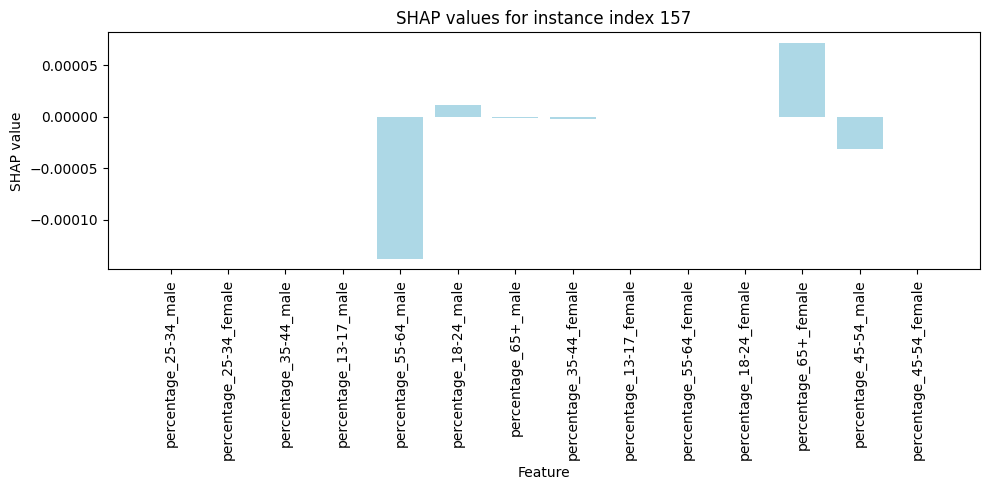

In [ ]:
feature_names = combined_train_data.columns.tolist()

explainer = shap.TreeExplainer(gb_model_gender)

instance_index = 157  # Index of the instance in the test set

single_instance = combined_test_data[instance_index:]

# Calculate SHAP values for the single instance
shap_values_single = explainer.shap_values(single_instance)

# Extract the SHAP values for the instance
shap_values_instance = shap_values_single[0] if isinstance(shap_values_single, list) else shap_values_single

shap_value_plot(feature_names[0:14], shap_values_instance[:,:14])

# **IMPRESSION PREDICTION WITH BERT**

CLEANING FOR BERT

In [11]:
import re

def filter_ibans(text):
    pattern = r'fr\d{2}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{2}|fr\d{20}|fr[ ]\d{2}[ ]\d{3}[ ]\d{3}[ ]\d{3}[ ]\d{5}'
    text = re.sub(pattern, '', text)
    return text

def remove_space_between_numbers(text):
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    return text

def filter_emails(text):
    pattern = r'(?:(?!.*?[.]{2})[a-zA-Z0-9](?:[a-zA-Z0-9.+!%-]{1,64}|)|\"[a-zA-Z0-9.+!% -]{1,64}\")@[a-zA-Z0-9][a-zA-Z0-9.-]+(.[a-z]{2,}|.[0-9]{1,})'
    text = re.sub(pattern, '', text)
    return text

def filter_ref(text):
    pattern = r'(\(*)(ref|réf)(\.|[ ])\d+(\)*)'
    text = re.sub(pattern, '', text)

    return text
def filter_websites(text):
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text

def filter_phone_numbers(text):
    pattern = r'(?:(?:\+|00)33[\s.-]{0,3}(?:\(0\)[\s.-]{0,3})?|0)[1-9](?:(?:[\s.-]?\d{2}){4}|\d{2}(?:[\s.-]?\d{3}){2})|(\d{2}[ ]\d{2}[ ]\d{3}[ ]\d{3})'
    text = re.sub(pattern, '', text)
    return text

def clean_text(text):
    text = text.lower()
    text = text.replace(u'\xa0', u' ')
    text = filter_phone_numbers(text)
    text = filter_emails(text)
    text = filter_ibans(text)
    text = filter_ref(text)
    text = filter_websites(text)
    text = remove_space_between_numbers(text)
    return text

In [20]:
train_data['ad_creative_bodies'] = train_data.ad_creative_bodies.apply(clean_text)

In [21]:
from transformers import DistilBertTokenizer

# Specify the model name
model_name = "distilbert-base-uncased"

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

encoded_corpus = tokenizer(text=train_data.ad_creative_bodies.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)

input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
import numpy as np

def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    lengths = tokenizer(descriptions, padding=False,
                     truncation=False, return_length=True)['length']
    for i in range(len(descriptions)):
        if lengths[i] <= max_len-2:
            indices.append(i)
    return indices

In [22]:
short_descriptions = filter_long_descriptions(tokenizer,
                               train_data.ad_creative_bodies.tolist(), 300)

input_ids = np.array(input_ids)[short_descriptions]
attention_mask = np.array(attention_mask)[short_descriptions]
labels = train_data.impressions.to_numpy()[short_descriptions].astype(np.float32) #target'ı impressions yaptım şu anlık
spends = train_data.spend.to_numpy()[short_descriptions].astype(np.float32) #cost'u impressions yaptım şu anlık

In [23]:
from sklearn.model_selection import train_test_split
validation_size = 0.1
seed = 42
train_inputs, validation_inputs, train_labels, validation_labels = \
            train_test_split(input_ids, labels, test_size=validation_size,
                             random_state=seed)

train_masks, validation_masks, _, _ = train_test_split(attention_mask,
                                        labels, test_size=validation_size,
                                        random_state=seed)

train_spends, validation_spends, _, _ = train_test_split(spends,
                                        labels, test_size=validation_size,
                                        random_state=seed)

In [24]:
from sklearn.preprocessing import StandardScaler
impression_scaler = StandardScaler()
impression_scaler.fit(train_labels.reshape(-1, 1))
train_labels = impression_scaler.transform(train_labels.reshape(-1, 1))
validation_labels = impression_scaler.transform(validation_labels.reshape(-1, 1))

cost_scaler = StandardScaler()
cost_scaler.fit(train_spends.reshape(-1, 1))
train_spends = cost_scaler.transform(train_spends.reshape(-1, 1))
validation_spends = cost_scaler.transform(validation_spends.reshape(-1, 1))

In [29]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
def create_dataloaders(inputs, masks, labels, spends, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    spends_tensor = torch.tensor(spends)
    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor, spends_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True, pin_memory=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, train_spends, batch_size)
validation_dataloader = create_dataloaders(validation_inputs, validation_masks,
                                     validation_labels, validation_spends, batch_size)

In [30]:
import torch.nn as nn
from transformers import DistilBertModel
class DistilBertRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bert=False):

        super(DistilBertRegressor, self).__init__()
        D_in, D_out = 768 + 1, 1

        self.distilbert = \
                   DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
              nn.Linear(D_in, D_out))

    def forward(self, input_ids, attention_masks, spends):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_masks)
        hidden_state = outputs[0]  # (batch_size, seq_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # Use the first token's embeddings
        # Concatenate pooled_output with spends
        combined_input = torch.cat((pooled_output, spends), dim=1)

        outputs = self.regressor(combined_input)
        return outputs


model = DistilBertRegressor(drop_rate=0.2)
model = model.to(torch.float)

In [31]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)

Using GPU.


DistilBertRegressor(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

In [32]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

In [33]:
from transformers import get_linear_schedule_with_warmup
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

In [34]:
loss_function = nn.MSELoss()

In [35]:
import torch
from torch.nn.utils.clip_grad import clip_grad_norm_
from sklearn.metrics import r2_score

def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value=2):
    loss_list = []  # List to store loss values
    r2_list = []  # List to store R2 scores
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-----")
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_inputs, batch_masks, batch_labels, batch_spends = tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks, batch_spends)
            loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

            # Calculate and save metrics every 20 batches
            if step % 100 == 0:
                # Calculate R2 score
                outputs_np = outputs.squeeze().detach().cpu().numpy()
                labels_np = batch_labels.squeeze().detach().cpu().numpy()
                r2 = r2_score(labels_np, outputs_np)
                r2_list.append((epoch, step, r2))
                loss_list.append((epoch, step, loss.item()))
                print(f"Batch {step}: Loss = {loss.item()}, R2 = {r2}")

    return model, loss_list, r2_list

# Sample call to the modified train function
model, loss_list, r2_list = train(model, optimizer, scheduler, loss_function, epochs,
                                  train_dataloader, device, clip_value=2)

Epoch 1/5
-----
Batch 0: Loss = 0.9761213064193726, R2 = -0.11879248613539173
Batch 100: Loss = 0.7211681008338928, R2 = 0.26915772089184065
Batch 200: Loss = 0.726841390132904, R2 = 0.20469071397634142
Epoch 2/5
-----
Batch 0: Loss = 0.7791694402694702, R2 = 0.22861095229879846
Batch 100: Loss = 0.6046490669250488, R2 = 0.3590926619094703
Batch 200: Loss = 0.6235414147377014, R2 = 0.377121000573275
Epoch 3/5
-----
Batch 0: Loss = 0.5036554336547852, R2 = 0.44007839974906293
Batch 100: Loss = 0.39658352732658386, R2 = 0.6529866787422369
Batch 200: Loss = 0.4249969720840454, R2 = 0.5820110146536046
Epoch 4/5
-----
Batch 0: Loss = 0.2417028546333313, R2 = 0.7442092494863584
Batch 100: Loss = 0.25883153080940247, R2 = 0.7341758882098286
Batch 200: Loss = 0.374376118183136, R2 = 0.6097254248621327
Epoch 5/5
-----
Batch 0: Loss = 0.18921014666557312, R2 = 0.8275851013318316
Batch 100: Loss = 0.15970627963542938, R2 = 0.8526389784874863
Batch 200: Loss = 0.15070095658302307, R2 = 0.869711476

SAVE THE MODEL

In [36]:
torch.save(model.state_dict(), "/content/drive/MyDrive/CS491MLMODEL/us/us/bert_regression.pth")

EVALUATION SET

In [ ]:
def evaluate(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

PREDICTION

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs,
                            batch_masks).view(1,-1).tolist()[0]
    return output

In [ ]:
val_set = val_data[['id_annonce', 'description', 'prix']]
val_set['cleaned_description'] = \
                val_set.description.apply(clean_text)
encoded_val_corpus = \
                tokenizer(text=val_set.cleaned_description.tolist(),
                          add_special_tokens=True,
                          padding='max_length',
                          truncation='longest_first',
                          max_length=300,
                          return_attention_mask=True)
val_input_ids = np.array(encoded_val_corpus['input_ids'])
val_attention_mask = np.array(encoded_val_corpus['attention_mask'])
val_labels = val_set.prix.to_numpy()
val_labels = price_scaler.transform(val_labels.reshape(-1, 1))
val_dataloader = create_dataloaders(val_input_ids,
                         val_attention_mask, val_labels, batch_size)
y_pred_scaled = predict(model, val_dataloader, device)

In [ ]:
y_test = val_set.prix.to_numpy()
y_pred = price_scaler.inverse_transform(y_pred_scaled)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mdape = ((pd.Series(y_test) - pd.Series(y_pred))\
         / pd.Series(y_test)).abs().median()
r_squared = r2_score(y_test, y_pred)

# **AGE PROBABILITY CLASSIFICATION WITH BERT**

LOAD DATAFRAME

In [4]:
df_age_filtered = pd.read_csv(ads_dataframe_age_filtered)
print(df_age_filtered.dtypes)
df_age_filtered.head()

ad_creation_time            object
ad_creative_bodies          object
currency                    object
impressions                 object
spend                       object
delivery_by_region          object
demographic_distribution    object
dtype: object


,ad_creation_time,ad_creative_bodies,currency,impressions,spend,delivery_by_region,demographic_distribution
0,2021-12-07,['As the quotation on the wall of the Holocaus...,USD,"{'lower_bound': '10000', 'upper_bound': '14999'}","{'lower_bound': '300', 'upper_bound': '399'}","[{'percentage': '0.002039', 'region': 'Hawaii'...","[{'percentage': '0.000213', 'age': '18-24', 'g..."
1,2021-12-07,['We need to call out all discrimination – whe...,USD,"{'lower_bound': '4000', 'upper_bound': '4999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.0003', 'region': 'Wyoming'}...","[{'percentage': '0.001782', 'age': '45-54', 'g..."
2,2021-12-07,['Too many on the right seem only concerned ab...,USD,"{'lower_bound': '2000', 'upper_bound': '2999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.002145', 'region': 'Alaska'...","[{'percentage': '0.000423', 'age': '45-54', 'g..."
3,2021-12-07,['As the quotation on the wall of the Holocaus...,USD,"{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.002674', 'region': 'Delawar...","[{'percentage': '0.016002', 'age': '25-34', 'g..."
4,2021-12-07,"[""Too many on the right seem only concerned ab...",USD,"{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100', 'upper_bound': '199'}","[{'percentage': '0.009534', 'region': 'Alabama...","[{'percentage': '0.000757', 'age': '35-44', 'g..."


CONVERT INTO DATAFRAME (AGE-GENDER FILTERING)

In [5]:
new_df_age_filtered = pd.DataFrame()

# Convert 'ad_creation_time' to datetime
new_df_age_filtered['ad_creation_time'] = pd.to_datetime(df_age_filtered['ad_creation_time'])

# Extract 'ad_creative_bodies'
new_df_age_filtered['ad_creative_bodies'] = df_age_filtered['ad_creative_bodies'].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else x).astype(str)

# Create columns for age intervals
unique_age_intervals = set()
for item in df_age_filtered['demographic_distribution']:
    try:
        demographics = ast.literal_eval(item)
        for demographic in demographics:
            age = demographic.get('age', None)
            gender = demographic.get('gender', None)
            if age is not None and gender is not None:
                age_gender_key = f'{age}_{gender}'
                unique_age_intervals.add(age_gender_key)
    except (SyntaxError, ValueError):
        pass

for age_interval in unique_age_intervals:
    new_df_age_filtered[f'percentage_{age_interval}'] = pd.Series(dtype='float32')

for i, item in enumerate(df_age_filtered['demographic_distribution']):
    try:
        demographics = ast.literal_eval(item)
        for demographic in demographics:
            age = demographic.get('age', None)
            gender = demographic.get('gender', None)
            if age is not None and gender is not None:
                age_gender_key = f'{age}_{gender}'
                new_df_age_filtered.at[i, f'percentage_{age_gender_key}'] = np.float32(demographic.get('percentage', 0))
    except (SyntaxError, ValueError):
        pass

# Display data types and the head of the new DataFrame
print(new_df_age_filtered.dtypes)
new_df_age_filtered.fillna(0, inplace=True)
new_df_age_filtered.head()

ad_creation_time              datetime64[ns]
ad_creative_bodies                    object
percentage_18-24_unknown             float32
percentage_Unknown_unknown           float32
percentage_65+_male                  float32
percentage_55-64_unknown             float32
percentage_45-54_male                float32
percentage_13-17_female              float32
percentage_45-54_unknown             float32
percentage_13-17_male                float32
percentage_25-34_female              float32
percentage_35-44_unknown             float32
percentage_35-44_female              float32
percentage_25-34_male                float32
percentage_65+_unknown               float32
percentage_35-44_male                float32
percentage_45-54_female              float32
percentage_55-64_male                float32
percentage_25-34_unknown             float32
percentage_13-17_unknown             float32
percentage_65+_female                float32
percentage_55-64_female              float32
percentage

,ad_creation_time,ad_creative_bodies,percentage_18-24_unknown,percentage_Unknown_unknown,percentage_65+_male,percentage_55-64_unknown,percentage_45-54_male,percentage_13-17_female,percentage_45-54_unknown,percentage_13-17_male,...,percentage_65+_unknown,percentage_35-44_male,percentage_45-54_female,percentage_55-64_male,percentage_25-34_unknown,percentage_13-17_unknown,percentage_65+_female,percentage_55-64_female,percentage_18-24_male,percentage_18-24_female
0,2021-12-07,As the quotation on the wall of the Holocaust ...,0.000213,0.0,0.055821,0.001595,0.142584,0.0,0.002764,0.0,...,0.002020,0.188836,0.074854,0.095481,0.001382,0.0,0.064646,0.079320,0.029452,0.002339
1,2021-12-07,We need to call out all discrimination – where...,0.000000,0.0,0.079002,0.001188,0.102762,0.0,0.001782,0.0,...,0.003861,0.062370,0.144936,0.109296,0.001485,0.0,0.183546,0.166023,0.012177,0.002970
2,2021-12-07,Too many on the right seem only concerned abou...,0.000000,0.0,0.050317,0.001691,0.079070,0.0,0.000423,0.0,...,0.002537,0.079070,0.127273,0.073996,0.002537,0.0,0.109514,0.129387,0.054123,0.013531
3,2021-12-07,As the quotation on the wall of the Holocaust ...,0.000000,0.0,0.128560,0.002441,0.125576,0.0,0.001899,0.0,...,0.003119,0.112558,0.071196,0.123135,0.000678,0.0,0.158530,0.123678,0.014375,0.003119
4,2021-12-07,Too many on the right seem only concerned abou...,0.000000,0.0,0.182290,0.002162,0.061953,0.0,0.001297,0.0,...,0.004757,0.041950,0.060980,0.101524,0.000973,0.0,0.334306,0.126500,0.007785,0.002703


MERGE COLUMNS AND SORT ACCORDING TO DATE

In [6]:
ads_dataframe_age_filtered = pd.DataFrame()
ads_dataframe_age_filtered['ad_creation_time'] = new_df_age_filtered['ad_creation_time']
ads_dataframe_age_filtered['ad_creative_bodies'] = new_df_age_filtered['ad_creative_bodies']

unknown_column = new_df_age_filtered['percentage_Unknown_unknown'] / 7

ads_dataframe_age_filtered['age-13-17'] = new_df_age_filtered["percentage_13-17_male"] + new_df_age_filtered["percentage_13-17_female"] + new_df_age_filtered["percentage_13-17_unknown"] + unknown_column
ads_dataframe_age_filtered['age-18-24'] = new_df_age_filtered["percentage_18-24_male"] + new_df_age_filtered["percentage_18-24_female"] + new_df_age_filtered["percentage_18-24_unknown"] + unknown_column
ads_dataframe_age_filtered['age-25-34'] = new_df_age_filtered["percentage_25-34_male"] + new_df_age_filtered["percentage_25-34_female"] + new_df_age_filtered["percentage_25-34_unknown"] + unknown_column
ads_dataframe_age_filtered['age-35-44'] = new_df_age_filtered["percentage_35-44_male"] + new_df_age_filtered["percentage_35-44_female"] + new_df_age_filtered["percentage_35-44_unknown"] + unknown_column
ads_dataframe_age_filtered['age-45-54'] = new_df_age_filtered["percentage_45-54_male"] + new_df_age_filtered["percentage_45-54_female"] + new_df_age_filtered["percentage_45-54_unknown"] + unknown_column
ads_dataframe_age_filtered['age-55-64'] = new_df_age_filtered["percentage_55-64_male"] + new_df_age_filtered["percentage_55-64_female"] + new_df_age_filtered["percentage_55-64_unknown"] + unknown_column
ads_dataframe_age_filtered['age-65+'] = new_df_age_filtered["percentage_65+_male"] + new_df_age_filtered["percentage_65+_female"] + new_df_age_filtered["percentage_65+_unknown"] + unknown_column

ads_dataframe_age_filtered

,ad_creation_time,ad_creative_bodies,age-13-17,age-18-24,age-25-34,age-35-44,age-45-54,age-55-64,age-65+
0,2021-12-07,As the quotation on the wall of the Holocaust ...,0.0,0.032004,0.203827,0.245083,0.220202,0.176396,0.122487
1,2021-12-07,We need to call out all discrimination – where...,0.0,0.015147,0.062073,0.130383,0.249480,0.276507,0.266409
2,2021-12-07,Too many on the right seem only concerned abou...,0.0,0.067654,0.183087,0.175053,0.206766,0.205074,0.162368
3,2021-12-07,As the quotation on the wall of the Holocaust ...,0.0,0.017494,0.094250,0.150123,0.198671,0.249254,0.290209
4,2021-12-07,Too many on the right seem only concerned abou...,0.0,0.010488,0.046275,0.067466,0.124230,0.230186,0.521353
...,...,...,...,...,...,...,...,...,...
199548,2018-12-26,"Corey R. Lewandowski and David N. Bossie, the ...",0.0,0.006410,0.010684,0.042735,0.202992,0.412393,0.324786
199549,2018-12-26,"Corey R. Lewandowski and David N. Bossie, the ...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
199550,2018-12-26,"NY Times best selling authors, Corey R. Lewand...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
199551,2018-12-24,Love your second amendment? Love knowing the t...,0.0,0.006910,0.020730,0.057256,0.188549,0.391905,0.334650


SPLIT TRAIN & TEST

In [7]:
# Determine the split index
split_value = 0.1
split_index = int(split_value * len(ads_dataframe_age_filtered))

train_data_age = ads_dataframe_age_filtered.iloc[:split_index]
test_data_age = ads_dataframe_age_filtered.iloc[split_index:]

In [12]:
train_data_age['ad_creative_bodies'] = train_data_age.ad_creative_bodies.apply(clean_text)

In [13]:
from transformers import DistilBertTokenizer

# Specify the model name
model_name = "distilbert-base-uncased"

# Load the tokenizer
tokenizer_age = DistilBertTokenizer.from_pretrained(model_name)

encoded_corpus_age = tokenizer_age(text=train_data_age.ad_creative_bodies.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)

input_ids_age = encoded_corpus_age['input_ids']
attention_mask_age = encoded_corpus_age['attention_mask']

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [16]:
import numpy as np

short_descriptions_age = filter_long_descriptions(tokenizer_age,
                               train_data_age.ad_creative_bodies.tolist(), 300)

input_ids_age = np.array(input_ids_age)[short_descriptions_age]
attention_mask_age = np.array(attention_mask_age)[short_descriptions_age]
# Select the age columns as labels. Adjust the column names as needed.
age_columns = ['age-13-17', 'age-18-24', 'age-25-34', 'age-35-44', 'age-45-54', 'age-55-64', 'age-65+']
labels_age = train_data_age[age_columns].to_numpy()[short_descriptions_age].astype(np.float32)

In [17]:
from sklearn.model_selection import train_test_split
validation_size = 0.1
seed = 42
train_inputs_age, validation_inputs_age, train_labels_age, validation_labels_age = \
            train_test_split(input_ids_age, labels_age, test_size=validation_size,
                             random_state=seed)

train_masks_age, validation_masks_age, _, _ = train_test_split(attention_mask_age,
                                        labels_age, test_size=validation_size,
                                        random_state=seed)

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True, pin_memory=True)
    return dataloader
train_dataloader_age = create_dataloaders(train_inputs_age, train_masks_age,
                                      train_labels_age, batch_size)
validation_dataloader_age = create_dataloaders(validation_inputs_age, validation_masks_age,
                                     validation_labels_age, batch_size)

In [21]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

class DistilBertClassifierAge(nn.Module):

    def __init__(self, drop_rate=0.2):
        super(DistilBertClassifierAge, self).__init__()
        # Input dimension for each token embedding from BERT
        D_in, D_out = 768, 7  # Output dimension matches the number of age categories

        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        # Define the regressor with a Dropout and a Linear layer
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out),
            nn.Softmax(dim=1)  # Ensure outputs are probabilities that sum to 1
        )

    def forward(self, input_ids, attention_masks):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_masks)
        hidden_state = outputs[0]  # (batch_size, seq_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # Use the first token's embeddings (CLS token)

        # Pass pooled_output through regressor to get final output
        logits = self.regressor(pooled_output)
        return logits

# Example of model creation and moving model to a device
model_age = DistilBertClassifierAge(drop_rate=0.2)
model_age = model_age.to(torch.float)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [22]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model_age.to(device)

Using GPU.


DistilBertClassifierAge(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

In [24]:
from transformers import AdamW
optimizer_age = AdamW(model_age.parameters(),
                  lr=5e-5,
                  eps=1e-8)

In [25]:
from transformers import get_linear_schedule_with_warmup
epochs_age = 5
total_steps_age = len(train_dataloader_age) * epochs_age
scheduler_age = get_linear_schedule_with_warmup(optimizer_age,
                 num_warmup_steps=0, num_training_steps=total_steps_age)

In [26]:
loss_function_age = nn.KLDivLoss(reduction='batchmean')

In [27]:
import torch
from torch.nn.utils.clip_grad import clip_grad_norm_
from sklearn.metrics import accuracy_score

def train_age(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value=2):
    loss_list = []  # List to store loss values
    accuracy_list = []  # List to store accuracy scores
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-----")
        model.train()
        total_correct = 0
        total_samples = 0
        for step, batch in enumerate(train_dataloader):
            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs, batch_labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

            # Calculate and save metrics every 100 batches
            if step % 50 == 0:
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                #total_correct = (predicted == labels_indices).sum().item()
                #total_samples = labels_indices.size(0)
                #accuracy = total_correct / total_samples
                #accuracy_list.append((epoch, step, accuracy))
                loss_list.append((epoch, step, loss.item()))
                print(f"Batch {step}: Loss = {loss.item()}")

    return model, loss_list

# Sample call to the modified train function
model_age, loss_list_age = train_age(model_age, optimizer_age, scheduler_age, loss_function_age, epochs_age,
                                  train_dataloader_age, device, clip_value=2)


Epoch 1/5
-----
Batch 0: Loss = -1.4107953310012817
Batch 50: Loss = -1.7404470443725586
Batch 100: Loss = -1.5736949443817139
Batch 150: Loss = -1.5957133769989014
Batch 200: Loss = -1.5872573852539062
Batch 250: Loss = -1.6706987619400024
Epoch 2/5
-----
Batch 0: Loss = -1.5922846794128418
Batch 50: Loss = -1.6082706451416016
Batch 100: Loss = -1.6316416263580322
Batch 150: Loss = -1.633455514907837
Batch 200: Loss = -1.540088176727295
Batch 250: Loss = -1.7155771255493164
Epoch 3/5
-----
Batch 0: Loss = -1.5678553581237793
Batch 50: Loss = -1.590296983718872
Batch 100: Loss = -1.720504641532898
Batch 150: Loss = -1.5319087505340576
Batch 200: Loss = -1.5857748985290527
Batch 250: Loss = -1.6795010566711426
Epoch 4/5
-----
Batch 0: Loss = -1.584427833557129
Batch 50: Loss = -1.557218074798584
Batch 100: Loss = -1.6972782611846924
Batch 150: Loss = -1.6040923595428467
Batch 200: Loss = -1.6168700456619263
Batch 250: Loss = -1.5188846588134766
Epoch 5/5
-----
Batch 0: Loss = -1.6647012